In [100]:
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoConfig, AutoTokenizer, Trainer, TrainingArguments, DefaultDataCollator, DataCollatorWithPadding
# AutoModel是不带头的模型加载，后面有For什么什么的是带头的模型加载
from datasets import load_dataset, Dataset, load_from_disk
from transformers import pipeline
from peft import get_peft_model, LoraConfig, TaskType
import torch
import sys
import os

In [ ]:
# 不带头的模型加载
# model = AutoModel.from_pretrained("hfl/chinese-macbert-base", trust_remote_code=True, device_map=1, output_attentions=True)

In [ ]:
# model.config

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("hfl/chinese-macbert-base", #指定加载什么模型，可以从本地加载也可以从Huggingface模型库加载，模型库复制名字就可以
                                             cache_dir="./huggingface_cache/chinese-macbert-base", #下载到本地的路径
                                             device_map="auto", #自动分配显存
                                             trust_remote_code=True, #信任远程代码，就是否使用模型作者自定义的代码，如果是HuggingFace自己的模型，就不用开，还是开一下好
                                             torch_dtype=torch.bfloat16 
                                             #使用半精度浮点数，节省显存，一般是float32，这样的话占4字节，0.1B的话就是占0.4GB显存，float16的话就是占2字节，0.1B就是占0.2GB显存，后面还有梯度(0.4GB)，激活值(和batch有关)，还有优化器参数（Adam的话就是0.8GB，一个梯度有两个要存的嘛）等等，加起来就很多了 
                                             #bf16和f16的差别在于，bf16范围更广，精度没有f16高，大模型经常会有梯度爆炸或者消失，而且注意力矩阵范围要求广，所以用bf16
                                             )
# 假如是分类模型，注意要传入num_labels参数
# model = AutoModelForSequenceClassification.from_pretrained("hfl/chinese-macbert-base", 
#                                             cache_dir="./huggingface_cache/chinese-macbert-base",
#                                             device_map="auto",
#                                             trust_remote_code=True,
#                                             torch_dtype=torch.bfloat16,
#                                             num_labels=2 #二分类
#                                             )

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model #这边看不到是bf16

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [18]:
# 看配置
model.config


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "bfloat16",
  "transformers_version": "4.55.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

In [17]:
# 也可以这样看：
config = AutoConfig.from_pretrained("hfl/chinese-macbert-base", trust_remote_code=True)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

In [19]:
model.config.output_attentions #看是否输出注意力矩阵, 默认是False的，不然占空间
# 这个参数你看上面的config是看不到的，你可以看到上面那个config是BertConfig，按ctrl单击可以进到BertConfig里面，发现BertConfig是继承自PretrainedConfig的，PretrainedConfig里面有个属性叫output_attentions

False

In [20]:
# 打印模型参数的名称和形状，通用方法
for name, param in model.named_parameters():
        print(name, param)
# 这里可以看得到打印出来是有bf16，说明是成功加载了bf16的模型

bert.embeddings.word_embeddings.weight Parameter containing:
tensor([[ 0.0311, -0.0070, -0.0532,  ...,  0.0723,  0.0209,  0.0225],
        [-0.0309,  0.0325,  0.0752,  ...,  0.0732,  0.0520,  0.0405],
        [ 0.0408, -0.0150,  0.0156,  ...,  0.0889, -0.0018, -0.0171],
        ...,
        [ 0.0374,  0.0099, -0.0067,  ...,  0.0342,  0.0608,  0.0427],
        [ 0.0471,  0.0520,  0.0200,  ...,  0.0559,  0.0150, -0.0109],
        [ 0.0093, -0.0366,  0.0040,  ...,  0.1147, -0.0457,  0.0187]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)
bert.embeddings.position_embeddings.weight Parameter containing:
tensor([[ 0.0220,  0.0238, -0.0157,  ..., -0.0708, -0.0261, -0.0140],
        [-0.0369,  0.0066, -0.0216,  ..., -0.0256, -0.0165,  0.0339],
        [-0.0171,  0.0024, -0.0208,  ..., -0.0461,  0.0142,  0.0309],
        ...,
        [-0.0205, -0.0334, -0.0013,  ...,  0.0354, -0.0134, -0.0150],
        [-0.0845, -0.0610, -0.0908,  ...,  0.0198,  0.0085, -0.0417],
        [-0

In [ ]:
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base") #默认都是fast的, 除非指定use_fast=False，最好是用fast，速度又快，功能又强
# 保存分词器
tokenizer.save_pretrained("./huggingface_cache/chinese-macbert-base") 
# 从本地加载分词器
# tokenizer = AutoTokenizer.from_pretrained("./huggingface_cache/chinese-macbert-base") 


('./huggingface_cache/chinese-macbert-base\\tokenizer_config.json',
 './huggingface_cache/chinese-macbert-base\\special_tokens_map.json',
 './huggingface_cache/chinese-macbert-base\\vocab.txt',
 './huggingface_cache/chinese-macbert-base\\added_tokens.json',
 './huggingface_cache/chinese-macbert-base\\tokenizer.json')

In [23]:
# 查看词典
tokenizer.vocab
# 查看词典大小
tokenizer.vocab_size

21128

In [ ]:
sen = "我爱北京天安门"
# 这样可以看分词的结果
tokens = tokenizer.tokenize(sen, 
                            # add_special_tokens=True 加上特殊符号，不加的话就没有[CLS]和[SEP]
)
print(tokens)
# 分词改成句子(字符串)
print(tokenizer.convert_tokens_to_string(tokens))
# 把分词改成分词之后的id
ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sen))
print(ids)
# 把id转成分词
print(tokenizer.convert_ids_to_tokens(ids))
# 把id转成句子
print(tokenizer.decode(ids)) # 中间会有空格，这个是没有办法的
# 也可以直接encode，直接把句子转成id
print(tokenizer.encode(sen, add_special_tokens=True)) #加上特殊符号
# encode还有encode_plus，encode_plus会返回一个字典，包含input_ids, attention_mask, token_type_ids等
print(tokenizer.encode_plus(sen, add_special_tokens=True))
# 有encode肯定也有decode
print(tokenizer.decode(tokenizer.encode(sen, add_special_tokens=True)))
print(tokenizer.decode(tokenizer.encode(sen, add_special_tokens=True), skip_special_tokens=True)) #跳过特殊符号

# 最方便的，直接丢进去，直接看分词的id，还会有attention_mask，token_type_ids等
# input_ids就是上面的tokens，不过会加上特殊符号
# attention_mask是attention的mask，1表示需要attention，0表示不需要attention
# token_type_ids是句子类型id，单句都是0，双句的话第一句是0，第二句是1
print(tokenizer(sen)) #和上面的encode_plus是一样的



['我', '爱', '北', '京', '天', '安', '门']
我 爱 北 京 天 安 门
[2769, 4263, 1266, 776, 1921, 2128, 7305]
['我', '爱', '北', '京', '天', '安', '门']
我 爱 北 京 天 安 门
[101, 2769, 4263, 1266, 776, 1921, 2128, 7305, 102]
{'input_ids': [101, 2769, 4263, 1266, 776, 1921, 2128, 7305, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS] 我 爱 北 京 天 安 门 [SEP]
我 爱 北 京 天 安 门
{'input_ids': [101, 2769, 4263, 1266, 776, 1921, 2128, 7305, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [46]:
# 还有很多参数的
tokenizer(sen, max_length=10, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)
# max_length是最大长度，padding是补齐方式，truncation是截断方式，return_tensors是返回的张量类型，pt是pytorch，tf是tensorflow，np是numpy
# 不只是能处理一条数据，直接把一堆数据丢进去也可以处理的，可以处理批量数据
print(tokenizer([sen, "我爱你中国"], max_length=10, padding="max_length", truncation=True, return_tensors="pt"))
# 你也可以只传入一条数据，但是返回的结果是批量的  
print(tokenizer(sen, max_length=10, padding="max_length", truncation=True, return_tensors="pt"))

{'input_ids': tensor([[ 101, 2769, 4263, 1266,  776, 1921, 2128, 7305,  102,    0],
        [ 101, 2769, 4263,  872,  704, 1744,  102,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}
{'input_ids': tensor([[ 101, 2769, 4263, 1266,  776, 1921, 2128, 7305,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}


In [ ]:
# 加载数据集
# 从本地jsonl文件加载数据集
dataset = load_dataset("json", data_files="./data/test.jsonl")
# 同时加载多个文件，这些文件注意，列要一样，不然没办法根据行来拼
# dataset = load_dataset("csv", data_files=["./data1.csv", "./data2.csv"], split='train')

# 或者：
# dataset = Dataset.from_json("./data/test.jsonl", lines=True)  # jsonl文件是每行一个json对象, 不加这个lines=True会报错
# 在线加载数据集，就是从HuggingFace上加载数据集，一般数据集都已经划分好了训练集和测试集
# dataset = load_dataset(dataset_name)), dataset_name是HuggingFace上面的数据集名字，比如"glue", "squad", "cnn_dailymail"等, 如果是数据集合集的话，还要指定是加载哪一个任务
# 按照划分来加载数据集
# dataset = load_dataset("squad", split="train") #加载SQuAD数据集的训练集
# dataset = load_dataset("squad", split="train", split="train[10:100]) #加载训练集的10-100条数据
# dataset = load_dataset("squad", split="train", split="train[:50%]") #加载训练集的前50%数据
# dataset = load_dataset("squad", split="train", split=["train[:50%]", "train[50%:]"]) #分两次分别加载训练集的前50%数据，后50%数据

In [84]:
# 用pandas加载也可以
import pandas as pd
data = pd.read_json("./data/company_city_location.json")  # 如果是jsonl文件，要加上lines=True，jsonl文件是每行一个json对象, 不加lines=True会报错
print(data.head())
dataset = Dataset.from_pandas(data)
dataset  # 把pandas的DataFrame转换成Dataset

          question                                            context  \
0     华为的总部位于哪个城市？      华为技术有限公司是一家全球领先的ICT基础设施和智能终端提供商，其总部设立在广东省深圳市。   
1      腾讯公司的总部在哪里？  腾讯成立于1998年11月，是目前中国领先的互联网增值服务提供商之一，总部位于广东省深圳市南山区。   
2  阿里巴巴的总公司设在什么地方？        阿里巴巴集团创立于1999年，是中国最大的电子商务企业，其总部位于浙江省杭州市余杭区。   
3   字节跳动的总部位于哪个城市？        字节跳动成立于2012年，旗下拥有抖音、今日头条等知名产品，公司总部位于北京市海淀区。   
4      百度公司的总部在哪里？   百度是中国领先的互联网搜索引擎公司，1999年创立于北京，总部位于北京市海淀区上地信息产业基地。   

           answer  
0          广东省深圳市  
1       广东省深圳市南山区  
2       浙江省杭州市余杭区  
3          北京市海淀区  
4  北京市海淀区上地信息产业基地  


Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 155
})

In [92]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer'],
        num_rows: 124
    })
    test: Dataset({
        features: ['question', 'context', 'answer'],
        num_rows: 31
    })
})

In [ ]:
# 查看dataset示例
dataset[0]
sample = dataset.select(range(5))
sample[0:5]

In [ ]:
tokenized_sample = tokenizer(text = sample["question"][0],
                             text_pair = sample["context"][0],
                             max_length=512,
                             truncation="only_second",
                             padding="max_length",         
                             return_offsets_mapping=True,
                             add_special_tokens=True,
                             )
print(tokenized_sample)
print(tokenized_sample.keys()) # offsets_mapping就是代表的是分词器分词的结果对应原来数据的词的索引，左闭右开

In [ ]:
# 划分数据集
dataset = dataset.train_test_split(test_size=0.2) #划分训练集和测试集，test_size是测试集的比例，默认是0.2，也就是20%，如果是0.1就是10%，如果是0.3就是30%，如果是0.5就是50%
# 可以按照特定的列来分层取样
# dataset = dataset['train'].train_test_split(test_size=0.2, stratify_by_column="label") #按照label列来分层取样

In [93]:
# 数据集的过滤
dataset = dataset.filter(lambda x: len(x['context']) > 0 and len(x['question']) > 0 and len(x['answer']) > 0) #过滤掉context, question, answer为空的样本
# 数据集的选取
# dataset = dataset.select(range(100)) #选取前100条数据
# dataset = dataset.select(range(100, 200)) #选取第100到第200条数据
# dataset = dataset.select([0,1])  # 选取第0条和第1条数据

Filter: 100%|██████████| 31/31 [00:00<?, ? examples/s]


In [ ]:
# 数据集映射和处理，自己定义一个process_function, 传入的参数是一条数据example，因为我们map的时候设置batch = False，如果你要开的话这里是要处理batch的example
def process_function(example):
    # 这里可以对example进行处理，比如分词，编码等
    # 具体要处理成什么样子，看你的Task，Task不同要求也不同的，比如这个是问答任务，你可能需要把context和question拼接起来，然后编码成id，还要有start_positions和end_positions等，这个要上HuggingFace的文档去看Task的示例是要什么样的数据
    tokenized_example = tokenizer(text = example["question"],
                             text_pair = example["context"],
                             max_length=128,
                             truncation="only_second", # 只对第二个text进行截断
                             padding="max_length",         
                             return_offsets_mapping=True, # 开启返回offset mapping
                             add_special_tokens=True,
                             )
    offset_mapping = tokenized_example.pop("offset_mapping")
    #  先确定文本的位置
    idx = 0
    while tokenized_example["token_type_ids"][idx] == 0:
        idx += 1
    context_start = idx
    while tokenized_example["token_type_ids"][idx] != 1:
        idx += 1
    context_end = idx - 1 # 左闭右闭
    # 现在确认答案的位置
    # 先判断答案在不在文本里面, 然后把词的位置找到是第几个
    if example["answer"] in example["context"]:
        answer_start = example["context"].find(example["answer"])
        answer_end = answer_start + len(example["answer"])
    else:
        answer_start = 0
        answer_end = 0
    # 现在确定一下答案在分词之后文本里的位置
    idx = 0
    while offset_mapping[idx][0] < answer_start:
        idx += 1
    answer_start_idx = idx
    while offset_mapping[idx][1] < answer_end:
        idx += 1
    answer_end_idx = idx
    tokenized_example["start_positions"] = answer_start_idx
    tokenized_example["end_positions"] = answer_end_idx
    return tokenized_example
    



Map: 100%|██████████| 31/31 [00:00<00:00, 10326.70 examples/s]


In [ ]:
# 映射数据集，使用map函数
processed_datasets = dataset.map(process_function, batched=False, remove_columns=dataset["train"].column_names)  # batched=True表示批量处理，默认是False，表示逐条处理


In [98]:
# 保存处理后的数据集到本地
# processed_datasets.save_to_disk("./processed_data")
# 加载处理后的数据集
# processed_datasets = load_from_disk("./processed_data")
# processed_datasets

In [103]:
# datacollator 是把处理好的数据集打包成batch的，默认是DefaultDataCollator, 也可以用DataCollatorWithPadding, 这个会自动补齐到最大长度
# collator = DataCollatorWithPadding(tokenizer=tokenizer)，记得需要传入tokenizer

#from torch.utils.data import DataLoader
#dl = DataLoader(tokenized_dataset, batch_size=4, collate_fn=collator, shuffle=True) 这个是pytorch的DataLoader，HuggingFace的Trainer会自动处理数据集的batch，所以不需要自己写DataLoader，一般弄好上面那个collator就可以了

In [113]:
# 评估函数
import evaluate
# 评估函数可以用HuggingFace的evaluate库，或者自己写
# 这里可以用HuggingFace的evaluate库来加载评估函数，比如SQuAD的评估函数
# squad_metric = evaluate.load("squad")  # 加载SQuAD的评估函数
# 也可以加载其他的评估函数，比如精确度
accuracy = evaluate.load("accuracy")  



In [114]:
# 看看有什么函数可以选择
evaluate.list_evaluation_modules()  # 列出所有可用的评估函数，不过可能不够全

['lvwerra/test',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsedykh/codebleu',
 'idsedykh/megaglue',
 'Vertaix/vendiscore',
 'GMFTBY/dailydialogevaluate',
 'GMFTBY/dailydialog_evaluate',
 'jzm-mailchimp/joshs_second_test_metric',
 'ola13/precision_at_k',
 'yulong-me/yl_metric',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 'KevinSpaghetti/accuracyk',
 'NimaBoscarino/weat',
 'ronaldahmed/nwentfaithfulness',
 'Viona/infolm',
 'kyokote/my_metric2',
 'kashif/mape',
 'Ochiroo/rouge_mn',
 'leslyarun/fbeta_score',
 'anz2/iliauniiccocrevaluation',
 'zbeloki/m2',
 'xu1998hz/sescore',
 'dvitel/codebleu',
 'NCSOFT/harim_plus',
 'JP-SystemsX/nDCG',
 'sportlosos/sescore',
 'Dru

In [ ]:
# 筛选一下，要比较模块的，然后不要社区自己创建的，要打印出详细信息，会发现都没有，正常，把社区设置为True就有了
evaluate.list_evaluation_modules(
  module_type="comparison",
  include_community=False,
  with_details=True)

[{'name': 'ncoop57/levenshtein_distance',
  'type': 'comparison',
  'community': True,
  'likes': 0},
 {'name': 'kaleidophon/almost_stochastic_order',
  'type': 'comparison',
  'community': True,
  'likes': 1},
 {'name': 'NeuraFusionAI/Arabic-Evaluation',
  'type': 'comparison',
  'community': True,
  'likes': 0}]

In [ ]:
accuracy # 打印出来可以看到教你怎么用，有参数的解释，有例子，看例子就行了，这里就不举例子了

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value('int32'), 'references': Value('int32')}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

    Exa

In [ ]:
print(accuracy.description) #看评估函数的描述


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative



In [ ]:
# 告诉你要输入什么样的数据来计算
print(accuracy.inputs_description)


Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

    Example 2-The same as Example 1, except with `normalize` set to `False`.
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> res

In [123]:
# 迭代处理，这里四个样本
accuracy = evaluate.load("accuracy")
for ref, pred in zip([0,1,0,1], [1,0,0,1]):
    accuracy.add(references=ref, predictions=pred)
accuracy.compute() #这里就不用传了

{'accuracy': 0.5}

In [122]:
# 迭代处理，这里是有四个样本，两个batch，一个batch有两个样本，拿refs来说，第一个batch是[0,1]，包含俩样本0，1；第二个是[0,1]，包含俩样本0，1
accuracy = evaluate.load("accuracy")
for refs, preds in zip([[0,1],[0,1]], [[1,1],[0,1]]):
    accuracy.add_batch(references=refs, predictions=preds)
accuracy.compute()

{'accuracy': 0.75}

In [124]:
# 组合多个评估函数
many_metrics = evaluate.combine(["accuracy", "f1", "recall", "precision"])  
many_metrics

In [ ]:
# 算一下看看：
many_metrics.compute(predictions=[0, 1, 0], references=[0, 1, 1])

{'accuracy': 0.6666666666666666,
 'f1': 0.6666666666666666,
 'recall': 0.5,
 'precision': 1.0}

Figure(640x480)


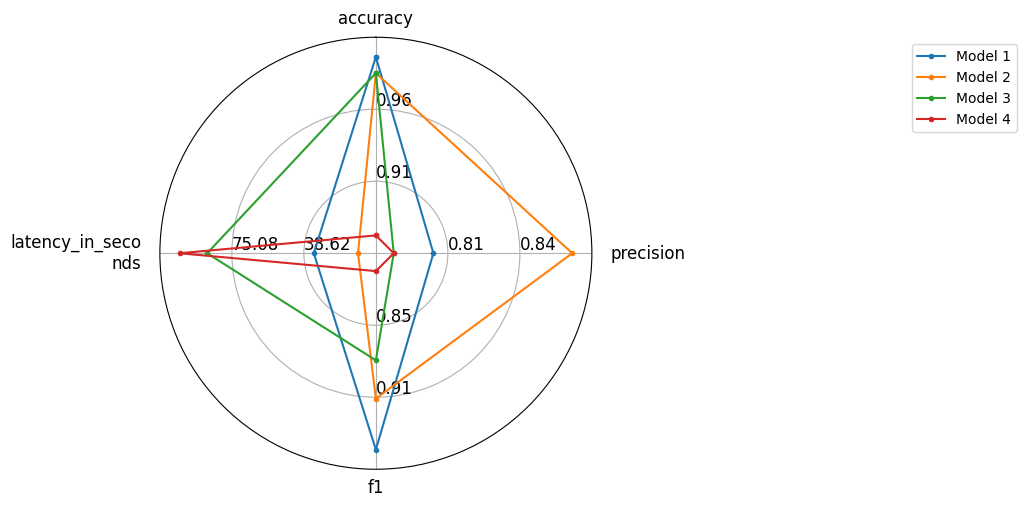

In [ ]:
# evaluate还可以做可视化
from evaluate.visualization import radar_plot #做雷达图

data = [
   {"accuracy": 0.99, "precision": 0.8, "f1": 0.95, "latency_in_seconds": 33.6},
   {"accuracy": 0.98, "precision": 0.87, "f1": 0.91, "latency_in_seconds": 11.2},
   {"accuracy": 0.98, "precision": 0.78, "f1": 0.88, "latency_in_seconds": 87.6}, 
   {"accuracy": 0.88, "precision": 0.78, "f1": 0.81, "latency_in_seconds": 101.6}
   ]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]
print(radar_plot(data=data, model_names=model_names))

In [ ]:
#以上的evaluate只是辅助我们写出自己的评估函数，除非你的任务很简单才能直接用

In [ ]:
# 训练
train_args = TrainingArguments(output_dir="./checkpoints",      # 输出文件夹
                               per_device_train_batch_size=1,   # 训练时的batch_size，显存小就设置小一点
                               per_device_eval_batch_size=1,    # 验证时的batch_size，显存小就设置小一点
                               logging_steps=20,                # log 打印的频率
                              # eval_strategy="epoch",           # 评估策略，也可以是step，step指的是步，弄一个batch就step加1，而epoch是完整遍历完一次数据集epoch就加1
                               save_strategy="epoch",           # 保存策略，跟评估策略保持一致
                               save_total_limit=2,              # 最大保存数
                               learning_rate=2e-5,              # 学习率
                               weight_decay=0.01,               # weight_decay
                              # metric_for_best_model="f1",      # 设定评估指标，这个是用于选择最优模型的，而且是根据键名来匹配的，具体是不是f1，是要看你的compute_metrics函数是怎么定义f1，它是从你那个函数的返回值里面找哪个是f1，不是真正的f1
                              # load_best_model_at_end=True    # 训练完成后加载最优模型
)
train_args


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
fp16=False,
fp1

In [ ]:
# collator = DefaultDataCollator()这个没办法实例化的，要在Trainer里面用
# collator = DataCollatorWithPadding(tokenizer=tokenizer) #这个是可以 

In [ ]:
trainer = Trainer(model=model, 
                  args=train_args, 
                  train_dataset=processed_datasets["train"], 
                  eval_dataset =processed_datasets["test"], 
                  data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
                # compute_metrics=accuracy.compute,  # 这里传入的是评估函数，注意要传入compute函数，不是evaluate对象, 不过一般也不用这种默认的，都是自己设置的
)
# 不传评估函数的话，就不会打印评估信息，也可以正常训练，但是像一些很麻烦很麻烦的那种评估函数，你不传它也给你弄好了

In [ ]:
trainer.train()  # 开始训练

In [ ]:
# 模型评估
trainer.evaluate(dataset["test"])  # 评估模型
# 模型预测
trainer.predict(dataset["test"])  # 预测模型

In [ ]:
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer, device_map="auto", torch_dtype=torch.float16) #记得要指定任务类型
pipe(question = "oppo的总公司在哪个城市", context = "oppo的总公司在广东省东莞市。")


Device set to use cuda:0


{'score': 0.008388333953917027, 'start': 0, 'end': 7, 'answer': 'oppo的总公'}

In [ ]:
# 这里详细说下关于pipeline的一些用法
from transformers.pipelines import SUPPORTED_TASKS
SUPPORTED_TASKS  # 打印所有支持的任务，tf上面那个就是可以指定的任务类型

{'audio-classification': {'impl': transformers.pipelines.audio_classification.AudioClassificationPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForAudioClassification,),
  'default': {'model': {'pt': ('superb/wav2vec2-base-superb-ks', '372e048')}},
  'type': 'audio'},
 'automatic-speech-recognition': {'impl': transformers.pipelines.automatic_speech_recognition.AutomaticSpeechRecognitionPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForCTC,
   transformers.models.auto.modeling_auto.AutoModelForSpeechSeq2Seq),
  'default': {'model': {'pt': ('facebook/wav2vec2-base-960h', '22aad52')}},
  'type': 'multimodal'},
 'text-to-audio': {'impl': transformers.pipelines.text_to_audio.TextToAudioPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForTextToWaveform,
   transformers.models.auto.modeling_auto.AutoModelForTextToSpectrogram),
  'default': {'model': {'pt': ('suno/bark-small', '1dbd7a1')}},
  'type': 

In [ ]:

pipe = pipeline("text-classification") 
# 根据任务类型来创建pipeline，是加载的默认模型，上面也可以看到默认模型是加载什么的，默认都是英文模型
# 特么的，这里不能放cache dir，不然报错，看来要先自己加载好model之后再用pipeline，不然都下到C盘真是要爆炸了
# pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device_map="auto", torch_dtype=torch.float16)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [163]:
# 测试一下
pipe(["good", "好"]) # 英文的，辨别中文确实错误率蛮高的，你看把好都认为是negative了

[{'label': 'POSITIVE', 'score': 0.9998161196708679},
 {'label': 'NEGATIVE', 'score': 0.6970562934875488}]

In [161]:
pipe.model.device

device(type='cuda', index=0)

In [ ]:
from transformers import TextClassificationPipeline
TextClassificationPipeline
pipe
# 上面这俩输出都差不多，所以pipe打印一下可以知道是什么任务的pipeline
# 具体的去官网查文档就行，不同的任务的参数用法传入格式等等是不一样的

transformers.pipelines.text_classification.TextClassificationPipeline